This code calculates the change of profile of Fields of Research (FoR) embeddings using semantic change approaches.


# Initialization


In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount = True) 
%ls '/gdrive/My Drive/SpringerNature-Google-Turing/data/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
 Five-year-sg-d100-w2-ns5/            Three-year-sg-d12-w2-ns1/
 Five-year-sg-d12-w4-ns1/             Three-year-sg-d12-w2-ns2/
 Five-year-sg-d12-w4-ns5/             Three-year-sg-d12-w2-ns3/
 for_co-occurrence_counts_11-13.csv   Three-year-sg-d12-w2-ns5/
 for_co-occurrence_counts_14-16.csv   Three-year-sg-d12-w4-ns1/
 for_co-occurrence_counts_17-19.csv   Three-year-sg-d12-w4-ns2/
'FoR mapping - Extract 1.csv'         Three-year-sg-d12-w4-ns3/
 FoR_W2V_v01.html      

In [0]:
import os
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict, OrderedDict
import numpy as np
import pandas as pd
from statistics import median, mean
from os import listdir
from os.path import isfile, join
import re
import plotly.express as px
import statistics

# Names of directories and files


In [0]:
BASE_DIR = '/gdrive/My Drive/SpringerNature-Google-Turing'
DATA_DIR = BASE_DIR + '/data'

## Hyperparameters

In [0]:
year_intervals = 3
num_dimensions = 12 # number of dimensions of embeddings
window_size = 4
negative_sampling = 3

# Functions

Function for defining first and last year


In [0]:
# Function that defines first and last year for embeddings:
def define_first_last_year(year_intervals):
  last_year = 2019
  if year_intervals == 3:
    first_year = 1990 
  elif year_intervals == 5:
    first_year = 1950
  return (first_year, last_year)

Function that defines the directory where the embeddings are



In [0]:
def define_directory(year_intervals, num_dimensions, window_size, negative_sampling):
  
  if year_intervals == 3:
    years_words = "Three"
  elif year_intervals == 5:
    years_words = "Five"
  DATA_DIR_yrs = DATA_DIR + '/' + years_words + '-year-sg-d' + str(num_dimensions) + '-w' + str(window_size) + '-ns' + str(negative_sampling)
  return DATA_DIR_yrs

Function for loading embeddings

In [0]:
# Function that loads the embeddings from the embedding file (From Khalid's and Donna's script)
def load_embeddings(embedding_file):

  embeddings = {}
  with open(os.path.join(DATA_DIR_yrs, embedding_file)) as file_reader:
    lines = file_reader.readlines()
    
    # skip the first line
    lines = lines[1:]

    # parse embedding lines
    for line in lines:
      parts = line.split(' ')
      embedding = [float(value) for value in parts[-num_dimensions:]]
      field = ' '.join(parts[:-num_dimensions])
      embeddings[field] = embedding

  return embeddings

Function that defines a dictionary that maps a year_start to the embedding file for that (year, year + year_intervals) period

In [0]:
def define_year2embeddings_dict(embeddingfiles):
  year2embeddings = dict() # dictionary that maps a year_start to the embedding file for that (year, year + year_intervals) period
  for f in embeddingfiles:
    m = re.match(r'wv_(\d\d)_(\d\d)', f)
    year_start = m.group(1)
    #year_end = m.group(2)
    #print("file", f, "Year start:", str(year_start), "Year end:", str(year_end))
    year2embeddings[int(year_start)] = f
  return(year2embeddings)

Function that defines a dictionary that maps a year_start with the embeddings for the (year, year + year_intervals-1) period; 

In [0]:
def define_all_embeddings_dict(first_year, last_year, year_intervals, year2embeddings_dict):
  all_embeddings_dict = dict() # Dictionary that maps a year_start with the embeddings for the (year, year + year_intervals-1) period; 
  # the embeddings are dictionaries that map a FoR to the list of its embedding's numeric values
  for y in range(first_year, last_year, year_intervals):
    #print("Year", str(y))
    y0 = int(str(y)[2:4])
    #print("y0=", str(y0))
    embeddings = load_embeddings(year2embeddings_dict[y0])
    all_embeddings_dict[y] = embeddings
  return all_embeddings_dict

Functions that define output file names


In [0]:
def define_eval_file_name(year_intervals, num_dimensions, window_size, negative_sampling):
  eval_file_name = BASE_DIR + '/analysis/evaluation/Evaluation-per-level1_yearint-' + str(year_intervals) + '_numdim-' + str(num_dimensions) + '_window-' + str(window_size) + '_negsamp-' + str(negative_sampling) + '.txt'
  return eval_file_name

def define_eval_file_summary_name(year_intervals, num_dimensions, window_size, negative_sampling):
  eval_file_summary_name = BASE_DIR + '/analysis/evaluation/Evaluation_yearint-' + str(year_intervals) + '_numdim-' + str(num_dimensions) + '_window-' + str(window_size) + '_negsamp-' + str(negative_sampling) + '.txt'
  return eval_file_summary_name

Function for calculating cosine similarity scores


In [0]:
def compute_pairwise_similarities(embedding_dict):
  # store pairwise similarities
  pairwise_embedding_similarities = defaultdict(dict)

  # get list of topics
  topics = list(embedding_dict.keys())

  total_similarity = 0
  similarity_distribution = list() # list of similarity values
  count = 0

  for i in range(len(topics)):
    #for j in range(i + 1, len(topics)):
    for j in range(len(topics)):
      topic_1 = topics[i]
      topic_2 = topics[j]
      #topic_1, topic_2 = max(topic_1, topic_2), min(topic_1, topic_2)

      # get first topic's embedding
      embed1 = embedding_dict[topic_1]
      # get second topic's embedding
      embed2 = embedding_dict[topic_2]
      # compute cosine similarity
      similarity = cosine_similarity([embed1], [embed2])
      # store in dictionary
      pairwise_embedding_similarities[topic_1][topic_2] = float(similarity)
      total_similarity += float(similarity)
      similarity_distribution.append(float(similarity))
      count += 1
  
  # Order topics by similarity
  for topic in pairwise_embedding_similarities:
    dictionary = pairwise_embedding_similarities[topic]
    sorted_dictionary = OrderedDict(sorted(dictionary.items(), key=lambda x: x[1], reverse=True))
    pairwise_embedding_similarities[topic] = sorted_dictionary

  return pairwise_embedding_similarities, total_similarity / count, median(similarity_distribution)

Functions for calculating neighbourhood similarity scores


In [0]:
def get_nearest_neighbours(similarities, topic, k):
  return list(similarities[topic].items())[1:k+1]

In [0]:
def get_neighbourhood(similarities, topic, distance):
  results = []
  for item in similarities[topic].items():
    t, similarity = item
    if similarity >= 1- distance and topic != t :
      results.append(item)
  return results

In [0]:
def get_neighbourhood_sizes(similarities, distance):
  results = {}
  sizes = []
  topics = list(similarities.keys())
  for topic in topics:
    results[topic] = len(get_neighbourhood(similarities, topic, distance))
    sizes.append(results[topic])
  return results, mean(sizes), median(sizes)


In [0]:
def get_average_neighbourhood_sizes(similarities, distances=np.arange(0.01, 0.11, 0.01)):
  sizes = {}
  for distance in distances:
    _, avg_size, median_size = get_neighbourhood_sizes(similarities, distance)
    sizes[round(distance, 3)] = round(avg_size, 5)
  return sizes

def get_median_neighbourhood_sizes(similarities, distances=np.arange(0.01, 0.11, 0.01)):
  sizes = {}
  for distance in distances:
    _, avg_size, median_size = get_neighbourhood_sizes(similarities, distance)
    sizes[round(distance, 3)] = round(median_size, 5)
  return sizes


# Read data

Read embedding files


In [119]:
DATA_DIR_yrs = define_directory(year_intervals, num_dimensions, window_size, negative_sampling)
first_last_years = define_first_last_year(year_intervals)
first_year = first_last_years[0]
last_year = first_last_years[1]
embeddingfiles = [f for f in listdir(DATA_DIR_yrs) if isfile(join(DATA_DIR_yrs, f))]
print("There are", str(len(embeddingfiles)), "embedding files")

There are 10 embedding files


Define years


In [120]:
range_years = list()
range_years = range(first_year+year_intervals, last_year, year_intervals)
years = [*range_years]
print(str(years))

[1993, 1996, 1999, 2002, 2005, 2008, 2011, 2014, 2017]


In [121]:
year2embeddings = define_year2embeddings_dict(embeddingfiles) # dictionary that maps a year_start to the embedding file for that (year, year + year_intervals) period
print(str(year2embeddings))

{17: 'wv_17_19.txt', 14: 'wv_14_16.txt', 11: 'wv_11_13.txt', 8: 'wv_08_10.txt', 5: 'wv_05_07.txt', 2: 'wv_02_04.txt', 99: 'wv_99_01.txt', 96: 'wv_96_98.txt', 93: 'wv_93_95.txt', 90: 'wv_90_92.txt'}


In [122]:
all_embeddings = define_all_embeddings_dict(first_year, last_year, year_intervals, year2embeddings) # Dictionary that maps a year_start with the embeddings for the (year, year + year_intervals-1) period; 
# the embeddings are dictionaries that map a FoR to the list of its embedding's numeric values
print(str(all_embeddings))

{1990: {'Clinical Sciences': [0.14045082, 0.5082515, 0.21792656, 0.06805022, 0.42567432, 0.24708751, 0.24165295, 0.48670885, -0.46311104, -0.19273148, -1.0910382, -0.4102097], 'Biochemistry and Cell Biology': [-0.09417949, -0.33378834, 0.7800359, 0.38991868, 0.05951909, -0.19962585, -0.16563573, 0.3295609, -0.72063226, -0.6338522, -0.64562505, -0.49770463], 'Physical Chemistry (incl. Structural)': [-1.8894297, 0.33655465, -0.3670552, 0.51358646, 0.34379736, 0.08467992, -0.11098363, 0.8694493, -1.3816738, 0.21619734, 0.27268842, 1.1281294], 'Neurosciences': [0.096149795, 0.4899056, 0.16981556, 0.07003866, 0.39205188, 0.2896561, 0.11629448, 0.44996026, -0.001977633, -0.22870696, -0.51132345, -0.44722393], 'Genetics': [-0.9348608, 0.25591034, 0.5740283, 0.39681336, 0.31923857, 0.3867432, -0.16000551, 1.232995, 0.28136918, -1.2894126, -1.2916784, -0.39950627], 'Materials Engineering': [-1.0519611, -0.35603765, -0.2666241, 0.25646627, 0.61367464, 0.012190738, -0.17795007, 0.844191, -1.17953

In [0]:
year2median_similarity = dict() # maps a year to the median similarity for that year
year2average_similarity = dict() # maps a year to the average similarity for that year
year2median_similarity = dict() # maps a year to the median similarity for that year
year2similarities = dict() # maps a year to the similarity scores for that year
for y in range(first_year+year_intervals, last_year, year_intervals):
  similarities_year, average_similarity_year, median_similarity_year = compute_pairwise_similarities(all_embeddings[y])
  year2average_similarity[y] = average_similarity_year
  year2median_similarity[y] = median_similarity_year
  year2similarities[y] = similarities_year

## Evaluation
Map level 2 FoRs to level 1 FoRs and calculate average cosine similarity within each level 1 FoR cluster: if this is higher than the average cosine similarity overall, then this is good.


Read level 1 to level 2 mapping:


In [124]:
level2_1_mapping_df = pd.read_csv(os.path.join(DATA_DIR, 'FoR mapping - Extract 1.csv'))
level2_1_mapping = dict()
for i in range(len(level2_1_mapping_df)):
  level2_1_mapping[level2_1_mapping_df.iloc[i].f2] = level2_1_mapping_df.iloc[i].f1
  #print("mapping level 2", level2_1_mapping_df.iloc[i].f2, "to level 1", level2_1_mapping_df.iloc[i].f1)
level2_1_mapping


{'Accounting, Auditing and Accountability': 'Commerce, Management, Tourism and Services',
 'Aerospace Engineering': 'Engineering',
 'Agricultural Biotechnology': 'Technology',
 'Agriculture, Land and Farm Management': 'Agricultural and Veterinary Sciences',
 'Analytical Chemistry': 'Chemical Sciences',
 'Animal Production': 'Agricultural and Veterinary Sciences',
 'Anthropology': 'Studies in Human Society',
 'Applied Economics': 'Economics',
 'Applied Ethics': 'Philosophy and Religious Studies',
 'Applied Mathematics': 'Mathematical Sciences',
 'Archaeology': 'History and Archaeology',
 'Architecture': 'Built Environment and Design',
 'Art Theory and Criticism': 'Studies in Creative Arts and Writing',
 'Artificial Intelligence and Image Processing': 'Information and Computing Sciences',
 'Astronomical and Space Sciences': 'Physical Sciences',
 'Atmospheric Sciences': 'Earth Sciences',
 'Atomic, Molecular, Nuclear, Particle and Plasma Physics': 'Physical Sciences',
 'Automotive Engineer

Open evaluation output files and write headers



In [125]:
eval_file_name = define_eval_file_name(year_intervals, num_dimensions, window_size, negative_sampling)
eval_file = open(eval_file_name, 'w')
eval_file.write('year\tlevel1\taverage_cosine_sim_FoR_mapped_to_this_level1\taverage_cosine_sim_all_FoR\n')
eval_file_summary_name = define_eval_file_summary_name(year_intervals, num_dimensions, window_size, negative_sampling)
eval_file_summary = open(eval_file_summary_name, 'w')
eval_file_summary.write('year\tnumber of cases in which average cosine similarity for level 2 FoR corresponding to the same level 1 FoR is higher than average cosine similarity for all level 2 FoR\n')

171

Average cosine similarity within each level 1 cluster


In [126]:
year2for2sims = dict()  # maps a year, level 1 FoR pair to the cosine similarity scores of level 2 FoRs corresponding to that level 1 FoR
total_successes = 0
for y in years:
  count_successes = 0 # this is the number of level 1 FoR for which the average cosine similarity between their corresponding level 2 FoR is higher than the overall average cosine similarity of all level 2 FoR
  print("year", str(y))
  average_same_level1 = dict() # this maps each level 1 FoR to the average cosine similarity between (level 2) FoRs which map to it
  similarities_y, average_similarity_y, median_similarity_y = compute_pairwise_similarities(all_embeddings[y]) # average_similarity_y is the overall average of all level 2 FoRs in year y
  fields = list(all_embeddings[y].keys())
  level1_cosine = dict() # this maps a level 1 FoR to the list of the cosine similarities between (level 2) FoRs which map to it
  for field1 in fields:
    top1 = level2_1_mapping[field1]
    for field2 in fields:
      if field1 != field2:
        top2 = level2_1_mapping[field2]
        cosine = similarities_y[field1][field2]
        if top1 == top2:
          #print(top1, str(cosine))
          if top1 in level1_cosine:
            list_cosines = level1_cosine[top1]
            list_cosines.append(cosine)
            level1_cosine[top1] = list_cosines
          else:
            level1_cosine[top1] = [cosine]
  for top in level1_cosine:
    average_same_level1[top] = float(sum(level1_cosine[top])/len(level1_cosine[top]))
    #print(top, str(average_same_level1[top]), str(average_similarity_y))
    eval_file.write(str(y)+'\t'+top+'\t'+str(average_same_level1[top])+'\t'+str(average_similarity_y)+'\n')
    year2for2sims[y,top] = average_same_level1[top]
    if average_same_level1[top] > average_similarity_y:
      count_successes += 1
      total_successes += 1
  eval_file_summary.write(str(y) + '\t' + str(count_successes) + '\n')
  print("There are ", str(count_successes), "success cases out of", str(len(level1_cosine.keys())))
eval_file_summary.write("Average number of successes:" + str(round(float(total_successes/len(years)),2)))


year 1993
There are  18 success cases out of 22
year 1996
There are  18 success cases out of 22
year 1999
There are  19 success cases out of 22
year 2002
There are  19 success cases out of 22
year 2005
There are  19 success cases out of 22
year 2008
There are  19 success cases out of 22
year 2011
There are  19 success cases out of 22
year 2014
There are  19 success cases out of 22
year 2017
There are  19 success cases out of 22


33

Close output files


In [0]:
eval_file.close()
eval_file_summary.close()

## Visualization

Create data frame for plotting


In [128]:
year2for2sims.items()
year2for2sims_df = pd.Series(year2for2sims).reset_index()   
year2for2sims_df.columns = ["year", "level1", "average_cosine"]
year2for2sims_df.head()
print(year2for2sims_df.describe())

              year  average_cosine
count   198.000000      198.000000
mean   2005.000000        0.595646
std       7.765602        0.239857
min    1993.000000       -0.225733
25%    1999.000000        0.483931
50%    2005.000000        0.670660
75%    2011.000000        0.772258
max    2017.000000        0.938650


Visualization


In [129]:
px.line(year2for2sims_df, x = "year", y = "average_cosine", color = "level1", hover_name = "level1")
#year2for2sims_df.plot.line()

In [130]:
year2for2sims_df

,year,level1,average_cosine
0,1993,Medical and Health Sciences,0.709819
1,1993,Biological Sciences,0.730750
2,1993,Chemical Sciences,0.798796
3,1993,Engineering,0.503287
4,1993,Psychology and Cognitive Sciences,0.250845
...,...,...,...
193,2017,History and Archaeology,0.649131
194,2017,Law and Legal Studies,0.062755
195,2017,Philosophy and Religious Studies,0.871174
196,2017,Built Environment and Design,0.773085


Test on 1993:

In [131]:
filter_year = year2for2sims_df['year']==1993
year2for2sims_df[filter_year].sort_values('average_cosine')

,year,level1,average_cosine
17,1993,Law and Legal Studies,-0.045012
11,1993,Technology,0.115366
4,1993,Psychology and Cognitive Sciences,0.250845
18,1993,"Language, Communication and Culture",0.307370
20,1993,Studies in Creative Arts and Writing,0.487404
3,1993,Engineering,0.503287
14,1993,"Commerce, Management, Tourism and Services",0.541767
21,1993,Built Environment and Design,0.582110
5,1993,Physical Sciences,0.604166
6,1993,Information and Computing Sciences,0.656084


Test on 2017:

In [132]:
filter_year = year2for2sims_df['year']==2017
year2for2sims_df[filter_year].sort_values('average_cosine')

,year,level1,average_cosine
194,2017,Law and Legal Studies,0.062755
180,2017,Psychology and Cognitive Sciences,0.212334
187,2017,Technology,0.261638
178,2017,Engineering,0.465255
192,2017,"Language, Communication and Culture",0.468772
190,2017,"Commerce, Management, Tourism and Services",0.496638
181,2017,Information and Computing Sciences,0.529728
182,2017,Physical Sciences,0.545009
197,2017,Studies in Creative Arts and Writing,0.560281
179,2017,Biological Sciences,0.608397


Average cosine similarity by level 1:

In [133]:
year2for2sims_df.groupby('level1').mean().sort_values('average_cosine')

,year,average_cosine
level1,,
Law and Legal Studies,2005,-0.000260
Technology,2005,0.146655
Psychology and Cognitive Sciences,2005,0.184718
Engineering,2005,0.482604
Studies in Creative Arts and Writing,2005,0.520508
Information and Computing Sciences,2005,0.539907
Built Environment and Design,2005,0.559881
Physical Sciences,2005,0.569978
"Language, Communication and Culture",2005,0.574554


Visualize

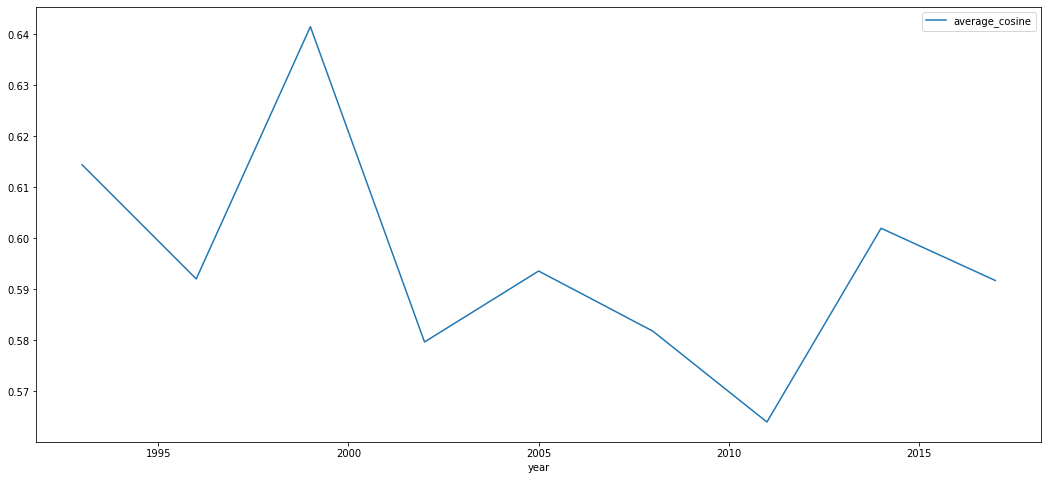

In [134]:
year2for2sims_df.groupby(['year']).mean().plot(figsize=(18,8))